In this work, we will not do a very detailed fine tuning. It will be more of a comparison based project. First, we will pull our data and create a basic CNN model and train it on our dataset consisting of 4 classes. Then we will call the DenseNet201 model and train without transfer learning. Then, again without changing any hyperparameters, this time we will include transfer learning and again we will consider the results. Finally, with all this data in hand, we will try how much we can increase our success rate with fine-tuning.

Let’s get started!

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!unrar x "/content/drive/MyDrive/raw_data (1).rar"

raw_data_dir = "/content/raw_data"
print(os.listdir(raw_data_dir))

categories = os.listdir(raw_data_dir)
num_of_categories = len(categories)
print("Counts of Images = {}".format(num_of_categories))

os.mkdir("data")
os.mkdir("premolar")
os.mkdir("molar")
os.mkdir("incisor")
os.mkdir("canine")

for i in categories:
  if "premolar" in i:
    shutil.move("/content/raw_data/" + i, "/content/premolar")
  elif "molar" in i:
    shutil.move("/content/raw_data/" + i, "/content/molar")
  elif "incisor" in i:
    shutil.move("/content/raw_data/" + i, "/content/incisor")
  elif "canine" in i:
    shutil.move("/content/raw_data/" + i, "/content/canine")

print("Count of Premolar: {}".format(len(os.listdir("premolar"))))
print("Count of Molar: {}".format(len(os.listdir("molar"))))
print("Count of Incisor: {}".format(len(os.listdir("incisor"))))
print("Count of Canine: {}".format(len(os.listdir("canine"))))

In [ ]:
import pathlib
!pip install split-folder
import split_folder
import keras
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
import os

data_dir = "/content/data"
split_folder.ratio(data_dir, output = "TrainValTestData", seed = 42,
                   ratio = (.7, .2, .1), group_prefix = None)


Copying (1921) of .. train/premolar



  0%|          | 0/1921 [00:00<?, ?it/s]


Copying (549) of .. val/premolar



  0%|          | 0/549 [00:00<?, ?it/s]


Copying (275) of .. test/premolar



  0%|          | 0/275 [00:00<?, ?it/s]


Copying (2223) of .. train/incisor



  0%|          | 0/2223 [00:00<?, ?it/s]


Copying (635) of .. val/incisor



  0%|          | 0/635 [00:00<?, ?it/s]


Copying (318) of .. test/incisor



  0%|          | 0/318 [00:00<?, ?it/s]


Copying (2333) of .. train/molar



  0%|          | 0/2333 [00:00<?, ?it/s]


Copying (666) of .. val/molar



  0%|          | 0/666 [00:00<?, ?it/s]


Copying (335) of .. test/molar



  0%|          | 0/335 [00:00<?, ?it/s]


Copying (1134) of .. train/canine



  0%|          | 0/1134 [00:00<?, ?it/s]


Copying (324) of .. val/canine



  0%|          | 0/324 [00:00<?, ?it/s]


Copying (163) of .. test/canine



  0%|          | 0/163 [00:00<?, ?it/s]

We add the necessary libraries and use split folder to randomly divide the dataset into 3 parts: train, test and validation. After that we need to create data generators for training, validation and test datasets. These generators are used to feed data into the model during training and validation. The ImageDataGenerator class provides a wide range of image augmentation options, which are transformations applied to the images to increase the amount of training data and prevent overfitting. The transformations include operations like rotations, translations, and flips. In the comment line for each code, the purpose for which it is written is explained in detail.

In [ ]:
train_dir = "/content/TrainValTestData/train"
test_dir = "/content/TrainValTestData/test"
val_dir = "/content/TrainValTestData/val"

In [ ]:
train_datagen = ImageDataGenerator(
   rescale = 1./255, # Rescale pixel values to the range [0, 1]
   rotation_range = 20, # Randomly rotate the images in the range of -20 to 20 degrees
   horizontal_flip = True, # Randomly flip the images horizontally
   fill_mode = "nearest" # Method used to fill in the gaps in the image after a rotation or flip
)

# Load your training dataset
# This method generates batches of images from the specified directory
train_generator = train_datagen.flow_from_directory(
   train_dir, # Directory where the training images are stored
   target_size = (224, 224), # Dimensions to which the images are resized
   batch_size = 32, # Number of images in each batch
   shuffle = True, # Whether to shuffle the images before creating batches
   class_mode = "categorical" # Format of the labels. In this case, the labels are one-hot encoded
)

# Create a data generator for the validation data
# This generator only rescales the images, without applying any augmentations
val_datagen = ImageDataGenerator(
   rescale=1./255 # Rescale pixel values to the range [0, 1]
)

# Load your validation dataset
val_generator = val_datagen.flow_from_directory(
   val_dir, # Directory where the validation images are stored
   target_size=(224, 224), # Dimensions to which the images are resized
   batch_size=32, # Number of images in each batch
   shuffle = True, # Whether to shuffle the images before creating batches
   class_mode='categorical' # Format of the labels. In this case, the labels are one-hot encoded
)

# Create a data generator for the test data
# This generator only rescales the images, without applying any augmentations
test_datagen = ImageDataGenerator(
   rescale=1./255 # Rescale pixel values to the range [0, 1]
)

# Load your test dataset
test_generator = test_datagen.flow_from_directory(
   test_dir, # Directory where the test images are stored
   target_size=(224, 224), # Dimensions to which the images are resized
   batch_size=32, # Number of images in each batch
   shuffle = True, # Whether to shuffle the images before creating batches
   class_mode='categorical' # Format of the labels. In this case, the labels are one-hot encoded
)

Found 7611 images belonging to 4 classes.
Found 2174 images belonging to 4 classes.
Found 1091 images belonging to 4 classes.


Now we are creating a Basic CNN for our first training.

In [ ]:
num_classes = 4

model = models.Sequential([
    layers.Conv2D(12, kernel_size=3, strides=1, padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(20, kernel_size=3, strides=1, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2),


    layers.Conv2D(32, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size = 3, strides = 1, padding = "same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),

    layers.Conv2D(128, kernel_size = 3, strides = 1, padding = "same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size = 2),

    layers.Flatten(),
    layers.Dense(360, activation='relu'),
    layers.Dense(120, activation='relu'),
    layers.Dense(num_classes, activation = "softmax")
])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 12)      336       
                                                                 
 batch_normalization_13 (Ba  (None, 224, 224, 12)      48        
 tchNormalization)                                               
                                                                 
 activation_17 (Activation)  (None, 224, 224, 12)      0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 12)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 20)      2180      
                                                                 
 activation_18 (Activation)  (None, 112, 112, 20)     

Here’s a breakdown of the structure:
- ***Convolutional Layers:*** These are the first layers of the CNN, where the input data is convolved with a set of learnable filters or kernels. The kernel slides over the input data, performing a dot product operation at each position, and generates a feature map. This process helps in extracting features from the input data. In this code, we have multiple Conv2D layers with different numbers of filters (12, 20, 32, 64, 128) and kernel sizes (3x3). Each Conv2D layer is followed by a BatchNormalization layer, which normalizes the output of the previous layer, and an Activation layer, which applies a non-linear function (ReLU in this case) to the output of the previous layer.
- ***MaxPooling Layer:*** This layer is used to reduce the spatial dimensions (width and height) of the output from the previous layer, which helps in reducing the computational cost and controlling overfitting. In this code, we have a MaxPooling2D layer after each Conv2D layer, with a pool size of 2.
- ***Flatten Layer:*** This layer is used to flatten the output from the previous layer into a one-dimensional array. This is necessary before feeding the output into a Dense (fully connected) layer.
- ***Dense Layers:*** These are fully connected layers where each neuron in the previous layer is connected to every neuron in the next layer. In this code, we have three Dense layers with varying numbers of units (360, 120, and ‘num_classes’). Each Dense layer is followed by an Activation layer, which applies a non-linear function (ReLU in the first two Dense layers and softmax in the last Dense layer) to the output of the previous layer.

The final layer uses the softmax function to output a probability distribution over the ‘num_classes’ classes. The class with the highest probability is chosen as the final prediction of the model.

Now, it’s training time.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator
)

Epoch 1/8
238/238 [==============================] - 129s 480ms/step - loss: 2.8775 - accuracy: 0.5061 - val_loss: 1.0658 - val_accuracy: 0.5419
Epoch 2/8
238/238 [==============================] - 111s 468ms/step - loss: 0.9365 - accuracy: 0.6120 - val_loss: 1.7236 - val_accuracy: 0.4236
Epoch 3/8
238/238 [==============================] - 113s 475ms/step - loss: 0.8787 - accuracy: 0.6397 - val_loss: 0.8100 - val_accuracy: 0.6564
Epoch 4/8
238/238 [==============================] - 112s 468ms/step - loss: 0.8133 - accuracy: 0.6781 - val_loss: 0.8870 - val_accuracy: 0.6270
Epoch 5/8
238/238 [==============================] - 111s 469ms/step - loss: 0.7145 - accuracy: 0.7138 - val_loss: 1.1995 - val_accuracy: 0.6003
Epoch 6/8
238/238 [==============================] - 114s 477ms/step - loss: 0.6143 - accuracy: 0.7660 - val_loss: 0.7777 - val_accuracy: 0.6983
Epoch 7/8
238/238 [==============================] - 110s 462ms/step - loss: 0.5155 - accuracy: 0.8038 - val_loss: 0.4613 - val_ac

Our Basic CNN model obtained 83% as the highest success rate at the end of 8 epochs. Considering that it has a simple structure, we can call it a serious success. Now let’s train with the DenseNet201 model without transfer learning.

In [ ]:
model = DenseNet201(weights = None, input_shape = (224, 224, 3), classes = 4)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator
)

Epoch 1/8
238/238 [==============================] - 311s 797ms/step - loss: 1.3712 - accuracy: 0.4727 - val_loss: 1.5206 - val_accuracy: 0.4480
Epoch 2/8
238/238 [==============================] - 177s 744ms/step - loss: 1.0678 - accuracy: 0.5711 - val_loss: 1.5531 - val_accuracy: 0.4936
Epoch 3/8
238/238 [==============================] - 178s 747ms/step - loss: 0.9075 - accuracy: 0.6366 - val_loss: 1.6548 - val_accuracy: 0.4733
Epoch 4/8
238/238 [==============================] - 180s 754ms/step - loss: 0.7932 - accuracy: 0.6903 - val_loss: 0.9200 - val_accuracy: 0.6352
Epoch 5/8
238/238 [==============================] - 181s 759ms/step - loss: 0.7350 - accuracy: 0.7167 - val_loss: 3.3950 - val_accuracy: 0.3339
Epoch 6/8
238/238 [==============================] - 176s 740ms/step - loss: 0.6650 - accuracy: 0.7439 - val_loss: 3.2836 - val_accuracy: 0.4738
Epoch 7/8
238/238 [==============================] - 178s 746ms/step - loss: 0.6038 - accuracy: 0.7719 - val_loss: 1.2144 - val_ac

"*weights = none*" and train without changing any other hyperparameters.
This resulted in a maximum success rate of 49.82%. Which is a pretty poor result. Let’s see how much the inclusion of transfer learning will affect our success.

In [ ]:
base_model = DenseNet201(weights = "imagenet", input_shape = (224, 224, 3), include_top=False)

# Set all layers in the base model to be non-trainable
# This means the weights of these layers will not be updated during training
for layer in base_model.layers:
  layer.trainable = False

# The output of the base model is taken as the input for the new model
x = base_model.output

# Add a GlobalAveragePooling2D layer to the model
# This layer averages the spatial dimensions (height and width) of the output from the previous layer
x = GlobalAveragePooling2D()(x)

# Add a Dense layer with 512 units and 'relu' activation function to the model
x = Dense(512, activation = "relu")(x)

# Add a Dropout layer with a rate of 0.4 to the model
# This layer randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting
x = Dropout(0.4)(x)

# Add a Dense layer with 4 units and 'softmax' activation function to the model
# This layer will output the probabilities for the 4 classes
predictions = Dense(4, activation='softmax')(x)

# Create a new model that takes the same input as the base model and outputs the predictions
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator
)

74836368/74836368 [==============================] - 2s 0us/step
Epoch 1/8
238/238 [==============================] - 158s 607ms/step - loss: 1.0218 - accuracy: 0.6567 - val_loss: 0.5497 - val_accuracy: 0.7723
Epoch 2/8
238/238 [==============================] - 131s 549ms/step - loss: 0.7198 - accuracy: 0.7125 - val_loss: 0.5176 - val_accuracy: 0.7953
Epoch 3/8
238/238 [==============================] - 130s 543ms/step - loss: 0.6938 - accuracy: 0.7233 - val_loss: 0.5082 - val_accuracy: 0.8169
Epoch 4/8
238/238 [==============================] - 142s 595ms/step - loss: 0.6676 - accuracy: 0.7278 - val_loss: 0.4815 - val_accuracy: 0.8174
Epoch 5/8
238/238 [==============================] - 131s 551ms/step - loss: 0.6523 - accuracy: 0.7370 - val_loss: 0.4621 - val_accuracy: 0.8261
Epoch 6/8
238/238 [==============================] - 130s 545ms/step - loss: 0.6466 - accuracy: 0.7448 - val_loss: 0.4726 - val_accuracy: 0.8155
Epoch 7/8
238/238 [==============================] - 134s 562ms/s

With the effect of transfer learning, we managed to increase the success rate from 49.82% to 82.61%. Now let’s see how much we can increase the success rate with fine-tuning.

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# This line sets the number of layers from the base model that will be fine-tuned during the training process.
fine_tune_at = 150


for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# We repeat the same actions as we did above.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Let's assign a different value to Leraning Rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)


model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# This line creates an early stopping callback that stops training when the validation accuracy does not improve for 5 epochs. It also restores the model weights from the epoch with the best validation accuracy.
early_stopping = keras.callbacks.EarlyStopping( monitor='val_accuracy',patience=5,restore_best_weights=True)


history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks= [early_stopping]
    )

Epoch 1/10
238/238 [==============================] - 241s 668ms/step - loss: 0.9702 - accuracy: 0.6108 - val_loss: 0.5484 - val_accuracy: 0.8293
Epoch 2/10
238/238 [==============================] - 157s 660ms/step - loss: 0.5008 - accuracy: 0.8154 - val_loss: 0.3112 - val_accuracy: 0.9048
Epoch 3/10
238/238 [==============================] - 158s 663ms/step - loss: 0.3277 - accuracy: 0.8824 - val_loss: 0.2223 - val_accuracy: 0.9278
Epoch 4/10
238/238 [==============================] - 158s 664ms/step - loss: 0.2457 - accuracy: 0.9153 - val_loss: 0.1798 - val_accuracy: 0.9425
Epoch 5/10
238/238 [==============================] - 156s 654ms/step - loss: 0.2072 - accuracy: 0.9287 - val_loss: 0.1584 - val_accuracy: 0.9508
Epoch 6/10
238/238 [==============================] - 170s 714ms/step - loss: 0.1667 - accuracy: 0.9439 - val_loss: 0.1445 - val_accuracy: 0.9531
Epoch 7/10
238/238 [==============================] - 168s 703ms/step - loss: 0.1392 - accuracy: 0.9547 - val_loss: 0.1365 -

With these small changes, we can reach up to 96% in validation success. Here you can see how valuable fine-tuning is and how much we can influence the result. Finally, let’s visualise the output of the result and complete the work.

35/35 [==============================] - 9s 239ms/step - loss: 0.1295 - accuracy: 0.9624


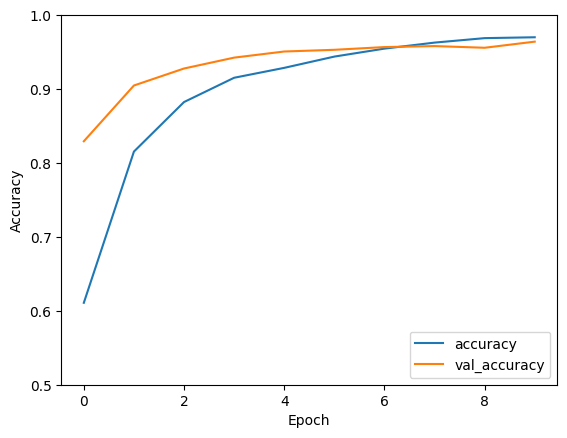

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_generator)

In [ ]:
print(test_loss)
print(test_acc)

0.1295010894536972
0.9624198079109192
